# Time to get your hands dirty: The HR diagram (...and the importance of data scaling in machine learning)
This assignment is about stars...

We will work with a star catalogue of 240 stars described by the following information:
- Temperature (in Kelvin)
- Luminosity (L/Lo)
- Radius (R/Ro)
- Absolute magnitude (Mv)

We also have the following data for each star:

- Color (Red/Orange/Yellow/White/Blue)
- Spectral class ('A', 'B', 'F', 'G', 'K', 'M', 'O')
- Star type (Brown dwarf/Red dwarf/White dwarf/Main sequence/Supergiant/Hypergiant)


- Apply PCA to the dataset at your disposal *(hint: don't use columns with labels, only those with real numbers)*.
- Project the dataset into the principal components, and do a scatter plot of the first two.
- This will look terrible. Think about the units!
- Explore what happens if you rescale the data first.

**This is actually a very important lesson in machine learning:**  
Massaging your data before giving them to an algorithm can make things much much better.

- You can try a linear, affine transformation such that each dimension goes between -1 and 1.
- Or (which is the [usual machine-learning approach](https://scikit-learn.org/stable/modules/preprocessing.html)) standardize your data such that each dimension has mean = 0 and variance = 1.
- Redo your PCA. Should be much much better.
- How much variance is explained by those two components?

---

## For later: come back to this assignment after lecture 20

- Now run a supervised classification algorithm on this dataset.
- Can you predict the stellar type? How well? Careful with overfitting of course.


In [59]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/nshaud/ml_for_astro/main/stars.csv", "stars.csv")


import pandas as pd
df_stars = pd.read_csv("stars.csv")


df_stars

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color,Spectral Class
0,3068,0.002400,0.1700,16.12,Brown Dwarf,Red,M
1,3042,0.000500,0.1542,16.60,Brown Dwarf,Red,M
2,2600,0.000300,0.1020,18.70,Brown Dwarf,Red,M
3,2800,0.000200,0.1600,16.65,Brown Dwarf,Red,M
4,1939,0.000138,0.1030,20.06,Brown Dwarf,Red,M
...,...,...,...,...,...,...,...
235,38940,374830.000000,1356.0000,-9.93,Hypergiant,Blue,O
236,30839,834042.000000,1194.0000,-10.63,Hypergiant,Blue,O
237,8829,537493.000000,1423.0000,-10.73,Hypergiant,White,A
238,9235,404940.000000,1112.0000,-11.23,Hypergiant,White,A


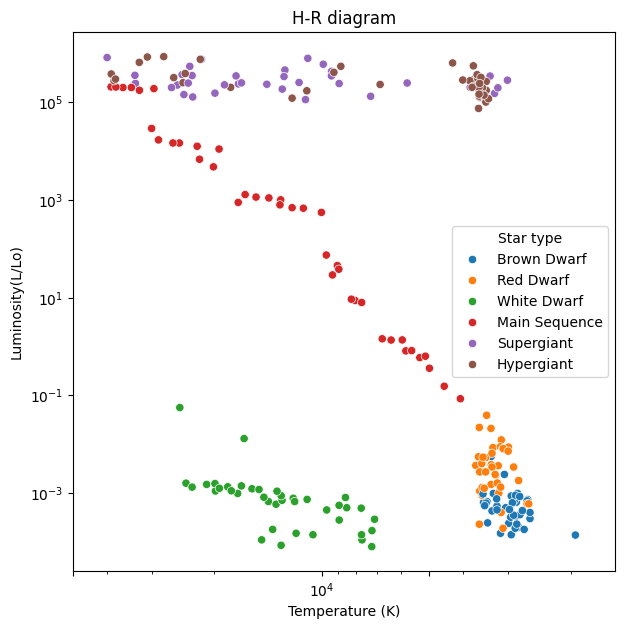

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(7, 7))
sns.scatterplot(data=df_stars, x='Temperature (K)', y='Luminosity(L/Lo)', hue='Star type')

plt.xscale('log')
plt.yscale('log')
plt.xticks([5000, 10000, 50000])
plt.xlim(5e4, 1.5e3)
plt.title("H-R diagram")
plt.show()


In [61]:
print(df_stars.isna().any().any()) #check for missing values

False


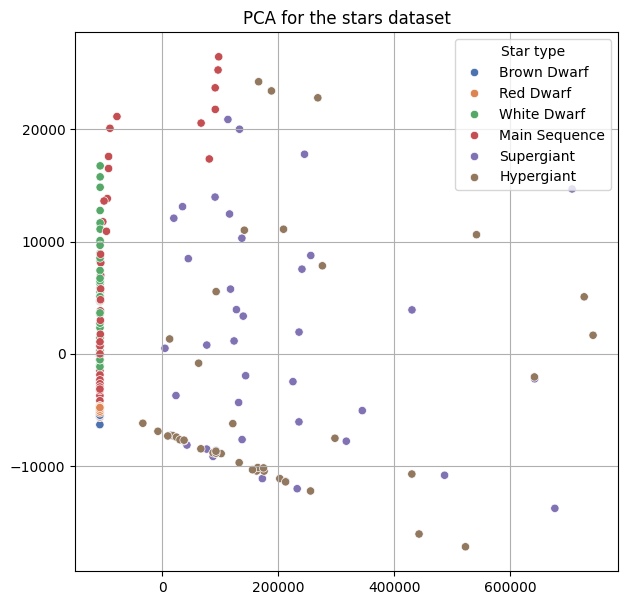

PCA 1° component explains 99.76% of the variance
PCA 2° component explains 0.24% of the variance
Combined (PC1 + PC2) explains 100.00% of the variance


In [62]:
from sklearn.decomposition import PCA

#let's ignore the column with words
features = df_stars.drop(columns=['Star color', 'Star type', 'Spectral Class'])

pca = PCA(n_components=2, svd_solver='randomized')
pca_result = pca.fit_transform(features)

plt.figure(figsize=(7, 7))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=df_stars['Star type'], palette='deep')
plt.title('PCA for the stars dataset')
plt.grid(True)
plt.show()

explained_var_ratio = pca.explained_variance_ratio_

# View variance explained by each component
print(f"PCA 1° component explains {explained_var_ratio[0]*100:.2f}% of the variance")
print(f"PCA 2° component explains {explained_var_ratio[1]*100:.2f}% of the variance")
print(f"Combined (PC1 + PC2) explains {(explained_var_ratio[0] + explained_var_ratio[1])*100:.2f}% of the variance")

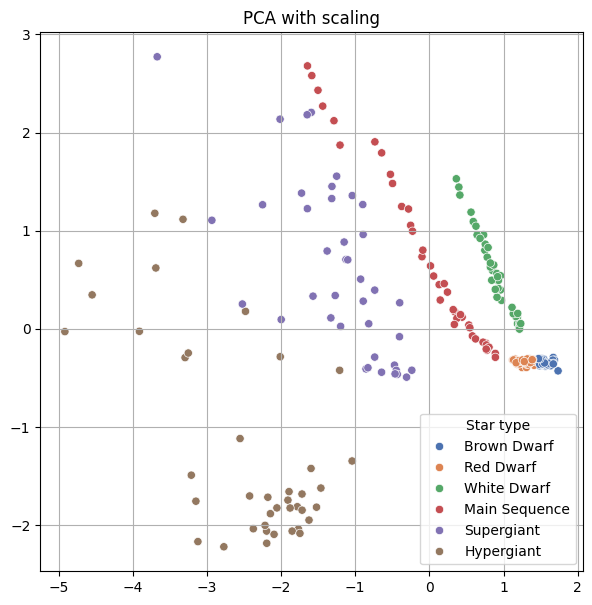

PCA 1° component explains 60.36% of the variance
PCA 2° component explains 23.50% of the variance
Combined (PC1 + PC2) explains 83.86% of the variance


In [63]:
# now, try the PCA by scaling the dataset 

from sklearn.preprocessing import StandardScaler
features = df_stars.drop(columns=['Star color', 'Star type', 'Spectral Class'])

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

#This scaling process is necessary because the variables have different scales.
#If I don't standardize the Temperature, being numerically much larger, it will dominate the PCA.
#Standardizing means transforming the data by centering them to 0 with a dispersion of 1.

pca = PCA(n_components=2, svd_solver='randomized')
pca_result = pca.fit_transform(features_scaled)

plt.figure(figsize=(7, 7))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=df_stars['Star type'], palette='deep')
plt.title('PCA with scaling')
plt.grid(True)
plt.show()

explained_var_ratio = pca.explained_variance_ratio_

# View variance explained by each component
print(f"PCA 1° component explains {explained_var_ratio[0]*100:.2f}% of the variance")
print(f"PCA 2° component explains {explained_var_ratio[1]*100:.2f}% of the variance")
print(f"Combined (PC1 + PC2) explains {(explained_var_ratio[0] + explained_var_ratio[1])*100:.2f}% of the variance")

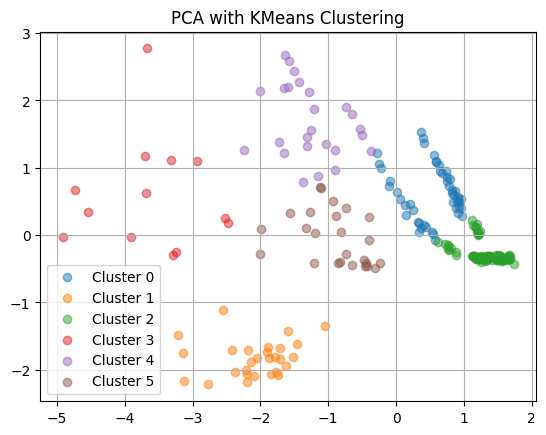

In [64]:
from sklearn.cluster import KMeans
from sklearn import preprocessing

kmeans = KMeans(n_clusters=6, n_init='auto', random_state=42)
kmeans.fit(pca_result)
labels = kmeans.predict(pca_result)

for i in range(6):
    plt.scatter(pca_result[labels == i, 0], pca_result[labels == i, 1], label=f'Cluster {i}', alpha=0.5)

plt.title('PCA with KMeans Clustering')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix
from scipy.stats import mode
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score 

# Converti etichette vere in numeri interi
le = LabelEncoder()
true_labels_encoded = le.fit_transform(df_stars['Star type'])

# Riassegna i cluster per allinearli ai veri label
new_labels = np.zeros_like(labels)
for cluster in np.unique(labels):
    mask = labels == cluster
    new_labels[mask] = mode(true_labels_encoded[mask], keepdims=True).mode[0]


cm = confusion_matrix(true_labels_encoded, new_labels)
print("Confusion Matrix:\n", cm)

print("Accuracy for the INCOMPLETE model:", accuracy_score(true_labels_encoded, new_labels))



Confusion Matrix:
 [[40  0  0  0  0  0]
 [ 0 38  0  0  2  0]
 [ 9  0  0  0 11 20]
 [40  0  0  0  0  0]
 [ 0  3  0  0 37  0]
 [11  0  0  0  0 29]]
Accuracy for the INCOMPLETE model: 0.6


In [66]:
#let's include the three columns with words

from sklearn.preprocessing import LabelEncoder

# change the columns with name into numbers
le_type = LabelEncoder()
le_color = LabelEncoder()
le_spec = LabelEncoder()

# Codify "Star type"
df_stars['Star type'] = le_type.fit_transform(df_stars['Star type'])
labels = le_type.inverse_transform(df_stars['Star type'])  # per i grafici
class_names = le_type.classes_
print("Star type:", class_names)

# Codify "Star color"
df_stars['Star color'] = le_color.fit_transform(df_stars['Star color'])
print("Star color:", le_color.classes_)

# Codify "Spectral Class"
df_stars['Spectral Class'] = le_spec.fit_transform(df_stars['Spectral Class'])
print("Spectral Class:", le_spec.classes_)


""""
that's do 2 things:
1. `le.fit(...)`: find all the unique values into the column 'Star type' (es. "White Dwarf", "Red Giant", ecc.).
2. `le.transform(...)`: give at each values an integer number (es. "White Dwarf" → 0, "Red Giant" → 1, ...).
"""

# ATTENZIONE, QUESTO NON STA MIGLIORANDO NULLA PERCHè PER COME LE HO CONVERTITE IPOTIZZO LINEARITà NEL CAMBIO DI COLORE,
# MA I VALORI NON SONO NE IN ORDINE CRESCENTE NE TANTO MENO EQUIDISTANTI!!
# QUESTO INTRODUCE RUMORE !!!


Star type: ['Brown Dwarf' 'Hypergiant' 'Main Sequence' 'Red Dwarf' 'Supergiant'
 'White Dwarf']
Star color: ['Blue' 'Blue ' 'Blue White' 'Blue white' 'Blue white ' 'Blue-White'
 'Blue-white' 'Orange' 'Orange-Red' 'Pale yellow orange' 'Red' 'White'
 'White-Yellow' 'Whitish' 'Yellowish' 'Yellowish White' 'white'
 'yellow-white' 'yellowish']
Spectral Class: ['A' 'B' 'F' 'G' 'K' 'M' 'O']


'"\nthat\'s do 2 things:\n1. `le.fit(...)`: find all the unique values into the column \'Star type\' (es. "White Dwarf", "Red Giant", ecc.).\n2. `le.transform(...)`: give at each values an integer number (es. "White Dwarf" → 0, "Red Giant" → 1, ...).\n'

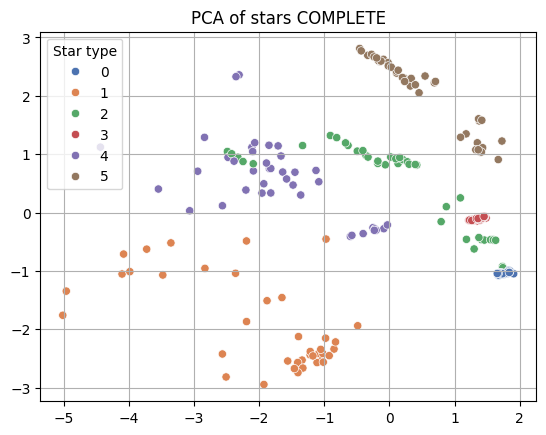

PCA 1° component explains 38.84% of the variance
PCA 2° component explains 27.44% of the variance
Combined (PC1 + PC2) explains 66.28% of the variance


In [67]:

scaler = StandardScaler()
features_scaled = scaler.fit_transform(df_stars)

pca = PCA(n_components=2, svd_solver='randomized')
pca_result = pca.fit_transform(features_scaled)

sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=df_stars['Star type'], palette='deep')
plt.title('PCA of stars COMPLETE')
plt.grid(True)
plt.show()

explained_var_ratio = pca.explained_variance_ratio_

# View variance explained by each component
print(f"PCA 1° component explains {explained_var_ratio[0]*100:.2f}% of the variance")
print(f"PCA 2° component explains {explained_var_ratio[1]*100:.2f}% of the variance")
print(f"Combined (PC1 + PC2) explains {(explained_var_ratio[0] + explained_var_ratio[1])*100:.2f}% of the variance")


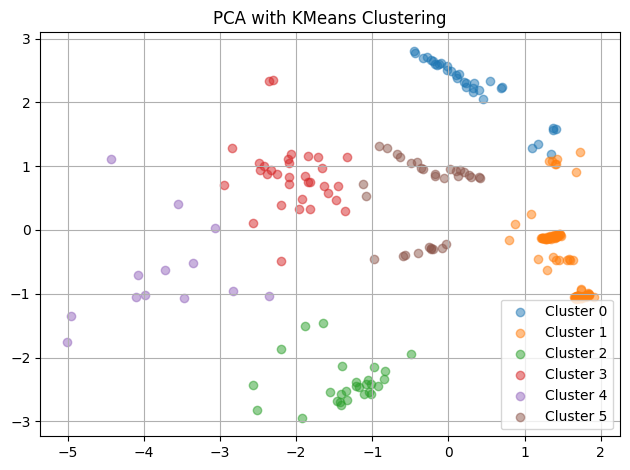

In [68]:
from sklearn.cluster import KMeans
from sklearn import preprocessing

kmeans = KMeans(n_clusters=6, n_init='auto', random_state=42)
kmeans.fit(pca_result)
labels = kmeans.predict(pca_result)

for i in range(6):
    plt.scatter(pca_result[labels == i, 0], pca_result[labels == i, 1], label=f'Cluster {i}', alpha=0.5)

plt.title('PCA with KMeans Clustering')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Converti etichette vere in numeri interi
true_labels_encoded = le.fit_transform(df_stars['Star type'])

# Riassegna i cluster per allinearli ai veri label
new_labels = np.zeros_like(labels)
for cluster in np.unique(labels):
    mask = labels == cluster
    new_labels[mask] = mode(true_labels_encoded[mask], keepdims=True).mode[0]

cm = confusion_matrix(true_labels_encoded, new_labels)
print("Confusion Matrix:\n", cm)

print("Accuracy for the COMPLETE model:", accuracy_score(true_labels_encoded, new_labels))



Confusion Matrix:
 [[40  0  0  0  0  0]
 [ 0 38  1  0  1  0]
 [14  0 20  0  6  0]
 [40  0  0  0  0  0]
 [ 0  3 11  0 26  0]
 [ 7  0  0  0  0 33]]
Accuracy for the COMPLETE model: 0.6541666666666667


Text(0.5, 1.0, 'TSNE result')

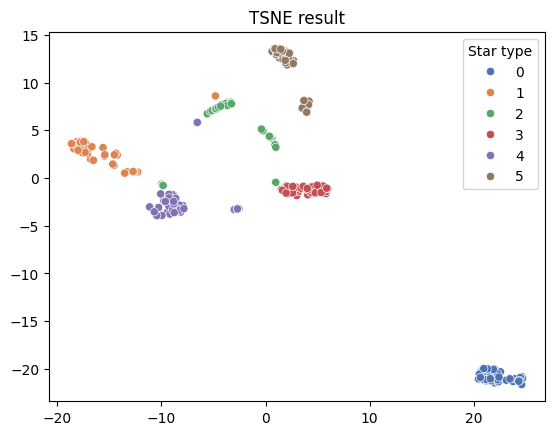

In [ ]:
from sklearn.manifold import TSNE #better then isomap
iso = TSNE(n_components=2)
iso_result = iso.fit_transform(features_scaled)

sns.scatterplot(x=iso_result[:, 0], y=iso_result[:, 1], hue=df_stars['Star type'], palette='deep')
plt.title("TSNE result")

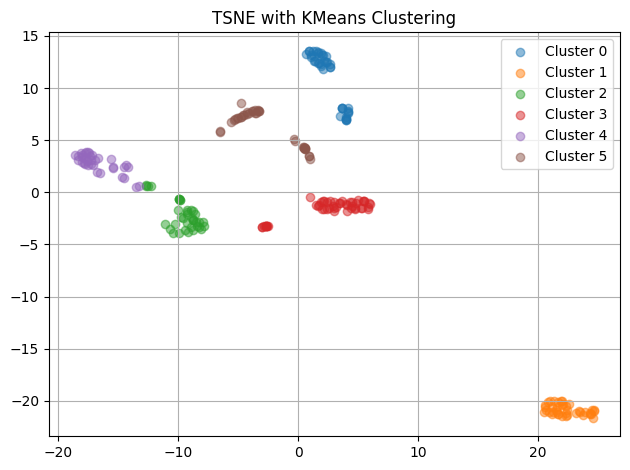

In [87]:
kmeans = KMeans(n_clusters=6, n_init='auto', random_state=42)
kmeans.fit(iso_result)
labels = kmeans.predict(iso_result)

for i in range(6):
    plt.scatter(iso_result[labels == i, 0], iso_result[labels == i, 1], label=f'Cluster {i}', alpha=0.5)

plt.title('TSNE with KMeans Clustering')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
true_labels_encoded = le.fit_transform(df_stars['Star type'])

# Riassegna i cluster per allinearli ai veri label
new_labels = np.zeros_like(labels)
for cluster in np.unique(labels):
    mask = labels == cluster
    new_labels[mask] = mode(true_labels_encoded[mask], keepdims=True).mode[0]

cm = confusion_matrix(true_labels_encoded, new_labels)
print("Confusion Matrix:\n", cm)

print("Accuracy for the TSNE model:", accuracy_score(true_labels_encoded, new_labels))

Confusion Matrix:
 [[40  0  0  0  0  0]
 [ 0 35  1  0  4  0]
 [ 0  0 34  1  5  0]
 [ 0  0  0 40  0  0]
 [ 0  0  2  9 29  0]
 [ 0  0  0  0  0 40]]
Accuracy for the TSNE model: 0.9083333333333333


In [106]:
from sklearn.model_selection import train_test_split

y_encoded = le.fit_transform(df_stars['Star type'])
X = iso_result

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.8, random_state=42, stratify=y_encoded)

Multiclass AUC (OvR): 0.993148

Metrics for each class:
Class               0: completeness = 1.00, contamination = 0.00
Class               1: completeness = 0.97, contamination = 0.00
Class               2: completeness = 1.00, contamination = 0.20
Class               3: completeness = 1.00, contamination = 0.00
Class               4: completeness = 0.94, contamination = 0.00
Class               5: completeness = 0.84, contamination = 0.00


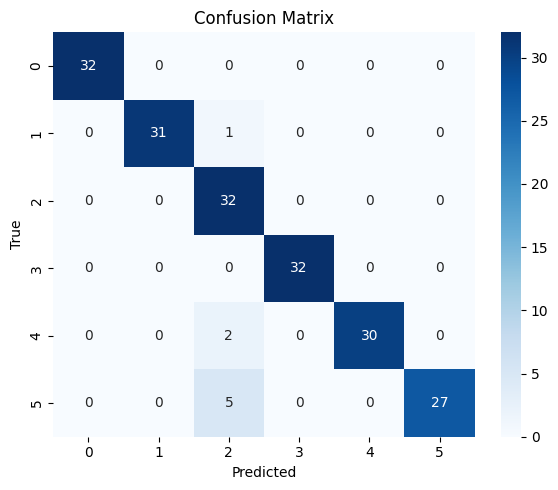

In [107]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score

ranfor = RandomForestClassifier(n_estimators=200, max_depth=7, criterion='entropy', n_jobs=-1)
ranfor.fit(X_train, y_train)

y_proba = ranfor.predict_proba(X_test)
auc_macro = roc_auc_score(y_test, y_proba, multi_class='ovr')  # thaat's for multy dimensional problem
print(f"Multiclass AUC (OvR): {auc_macro:.6f}")

# Prediction
y_pred = ranfor.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

#  completeness (recall) and contamination (1 - precision)
completeness = np.diag(cm) / np.sum(cm, axis=1)
contamination = 1 - (np.diag(cm) / np.sum(cm, axis=0))

print("\nMetrics for each class:")
for i, label in enumerate(le.classes_):
    print(f"Class {label:15}: completeness = {completeness[i]:.2f}, contamination = {contamination[i]:.2f}")

#heatmap of the final confusion matrix , how cool!
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()
